In [1]:
pip install leafmap

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import requests
import pandas as pd
import geopandas as gpd
from shapely import wkt
import ipywidgets as widgets
import matplotlib.pyplot as plt
import folium
from shapely.geometry import mapping
import leafmap as leafmap
from shapely.geometry import shape

def read_response(t):
    try:
        data = t.json() #This will convert the response to a json object
        return data
    except requests.exceptions.JSONDecodeError:
        print("Risposta non valida JSON!")
        print("Contenuto della risposta:", t.text)
        data = None 

def get_measurement_unit(pollutant):
    t=requests.post(url="http://127.0.0.1:5000/api/units", json={"var_pollutant": pollutant}) #json= data will convert the dictionary to a json object and send it to the server
    data = read_response(t) 
    return data[0]
    
def get_province_shape():
    t=requests.get(url="http://127.0.0.1:5000/api/province_shape")
    data = read_response(t)
    gdf = gpd.GeoDataFrame(data)
    gdf['geometry_province'] = gdf['geometry_province'].apply(wkt.loads)
    gdf.set_geometry('geometry_province', inplace=True)
    return gdf
prov=get_province_shape()

def list_sensors_and_pollutants(list_stations):
    t=requests.post(url="http://127.0.0.1:5000/api/sensors_and_pollutants", json={"var_id_stazione": list_stations}) #json= data will convert the dictionary to a json object and send it to the server
    data = read_response(t) 
    return data

def get_station_location():
    t=requests.get(url="http://127.0.0.1:5000/api/station_location")
    data = read_response(t)
    gdf = gpd.GeoDataFrame(data)
    gdf['geometry'] = gdf['geometry'].apply(wkt.loads)
    gdf.set_geometry('geometry', inplace=True)
    return gdf

# DV_5 Single Sensor Time Series

Start by selecting a pollutant, then select one among all the sensors that measures that pollutant, and then visualize in the graph the time series of the monthly average of the data measured by that sensor


Select the pollutant

In [76]:
t=requests.get(url="http://127.0.0.1:5000/api/pollutant")
list_pollutant_5 = read_response(t)
Selected_pollutant_5 = widgets.Dropdown(
    options=list_pollutant_5,
    value=list_pollutant_5[0],
    default=list_pollutant_5[0],
    description='Pollutant:',
    disabled=False, 
)
Selected_pollutant_5

Dropdown(description='Pollutant:', options=('Ammoniaca', 'Arsenico', 'Benzene', 'Benzo(a)pirene', 'Biossido di…

Select one of the sensors that measures that pollutant

In [77]:
ts=requests.post(url="http://127.0.0.1:5000/api/sensor", json={"var_pollutant": Selected_pollutant_5.value})
list_sensors_5 = read_response(ts)
Selected_sensor_5 = widgets.Dropdown(
    options=list_sensors_5,
    value=list_sensors_5[0],
    default=list_sensors_5[0],
    description='Sensor:',
    disabled=False, 
)
Selected_sensor_5

Dropdown(description='Sensor:', options=({'id_sensore': 12590, 'nome_stazione': 'Brescia Villaggio Sereno'}, {…

In [78]:
# DV-5
data = {"var_sensor_id": Selected_sensor_5.value["id_sensore"], "var_pollutant": Selected_pollutant_5.value} #Right now data is a dictionary
# send the request to the server, we use post because we are sending data to the server
t=requests.post(url="http://127.0.0.1:5000/api/DV_5", json=data) #json= data will convert the dictionary to a json object and send it to the server

data = read_response(t) 
df = pd.DataFrame(data) #Convert the json object to a pandas dataframe

Plot the time series

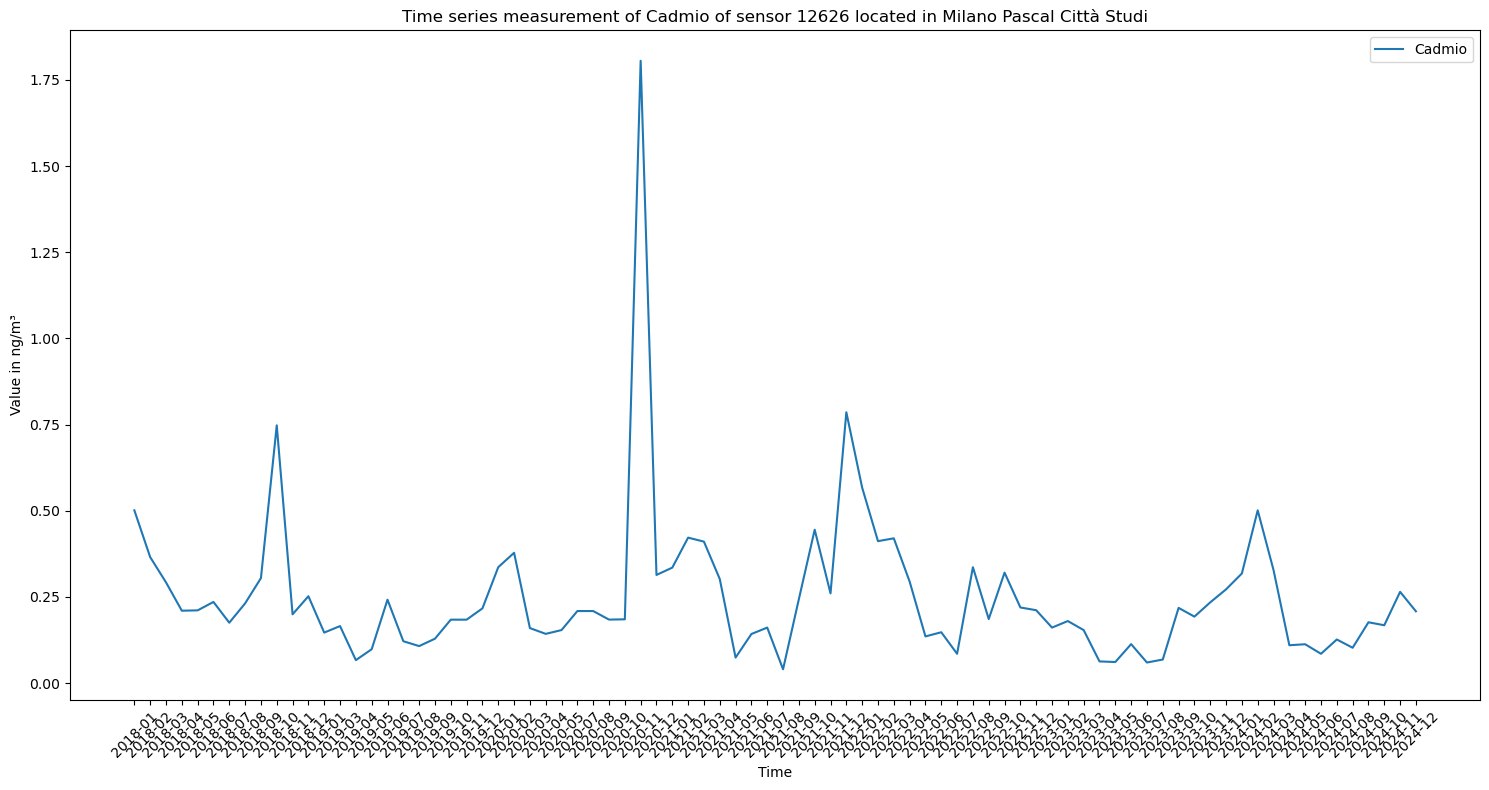

In [79]:
if len(df)==0:
    print("The query returned an empty dataframe")
else:
    plt.figure(figsize=(15, 8))
    df["month"] = pd.to_datetime(df["month"]).dt.strftime("%Y-%m") #Convert the data to a datetime object and format it to YYYY-MM
    plt.plot(df["month"], df["monthly_avg"], label=Selected_pollutant_5.value)  #Plot the data, x axis is "data" and y axis is "valore"
    plt.legend()  #Prints the legend on the graph
    plt.title(f"Time series measurement of {Selected_pollutant_5.value} of sensor {Selected_sensor_5.value["id_sensore"]} located in {Selected_sensor_5.value["nome_stazione"]}")  #Prints the title on top of graph
    plt.xlabel("Time")  # Prints X axis label as "X-axis"
    units=get_measurement_unit(Selected_pollutant_5.value) #Get the measurement unit of the pollutant
    plt.ylabel(f"Value in {units}")  # Prints Y axis label as "Y-axis"
    plt.xticks(rotation=45)

    # Migliora leggibilità delle etichette
    plt.tight_layout()
    plt.show()

# DV_6 Location of all the sensors of a selected pollutant

Chose a pollutant, and then visualize on a map the location af all the sensors of that pollutant. The sennsor will appear red if it's still active, and will appear gray if it is not active anymore. 

Clicking on the icon of a sensor the user can visualiza the id of the sensor, the name of the station in which the sensor is located and date in which the sensor was deactivated, if it is not active anymore

In [80]:
t=requests.get(url="http://127.0.0.1:5000/api/all_pollutant")
list_pollutant_6 = read_response(t)
Selected_pollutant_6 = widgets.Dropdown(
    options=list_pollutant_6,
    value=list_pollutant_6[0],
    default=list_pollutant_6[0],
    description='Pollutant:',
    disabled=False, #Because we want the user to be able to select the province
)
Selected_pollutant_6

Dropdown(description='Pollutant:', options=('Ammoniaca', 'Arsenico', 'Benzene', 'Benzo(a)pirene', 'Biossido di…

In [81]:
# DV-6
data = {"var_pollutant" : Selected_pollutant_6.value} #Right now data is a dictionary

# send the request to the server, we use post because we are sending data to the server
t=requests.post(url="http://127.0.0.1:5000/api/DV_6", json=data) #json= data will convert the dictionary to a json object and send it to the server

data = read_response(t)
gdf = gpd.GeoDataFrame(data)
gdf['geometry'] = gdf['geometry'].apply(wkt.loads)
gdf.set_geometry('geometry', inplace=True)

map documentation: [folium documentation](https://python-visualization.github.io/folium/latest/user_guide/geojson/geopandas_and_geo_interface.html)

In [82]:
if len(gdf)==0:
    print("The query returned an empty dataframe")
else:
    # create a simple Folium map with markers and popups
    m = folium.Map(location=[45.64, 9.60], zoom_start=8, tiles="OpenStreetMap")
    # iterate through the GeoDataFrame and add a marker for each station by extracting its coordinates and the popup content
    fg_active = folium.FeatureGroup(name="Active sensor", show=True).add_to(m)
    fg_inactive = folium.FeatureGroup(name="Inactive sensor", show=True).add_to(m)
    for index, row in gdf.iterrows():
        if row['data_stop'] is None:
            html = (f"<b>{row['id_sensore']}-{row['nome_stazione']} <br><br>active</b>")
            popup = folium.Popup(html, max_width=200)

            folium.Marker(
                location=[row['geometry'].y,row['geometry'].x], 
                popup=popup,
                icon=folium.map.Icon(color='red')
            ).add_to(fg_active)
        else:
            html = (f"<b>{row['id_sensore']}-{row['nome_stazione']} <br><br> deactivated on {row['data_stop']}</b>")
            popup = folium.Popup(html,max_width=200)
            folium.Marker(
                location=[row['geometry'].y,row['geometry'].x], 
                popup=popup,
                icon=folium.map.Icon(color='gray')
            ).add_to(fg_inactive)

    #Add province layer
    geojson = mapping(prov.geometry_province) 
    folium.GeoJson(geojson, name="Provinces", ).add_to(m)
    folium.LayerControl().add_to(m)
    display(m)

# EU_DV_1 Selection of the Region Of Interest

In this section an exper user can select a region of interest on the map using the buttons on the left. Once the region of interest has been selected the user can visualiza how many stations are inside teh area of interest and then on the map he can visualize these stations. 

The station will appear red if it contains at least one active sensor, otherwise it will be gray.

By clicking on the icon of a station the user can visualiza which sensors are inside the station, the pollutant they measure and the date in which they have been deactivated, if they are not active anymore


[documentation leaflet](https://leafmap.org/leafmap/#leafmap.leafmap.Map.add_gdf)

In [91]:
m = leafmap.Map(center=[45.64, 9.60], zoom=8)
lombardia = prov.dissolve()  
m.add_gdf(lombardia, layer_name="Lombardia", hover_style={"fill_colors":"blue"}, info_mode=None)
m

Map(center=[45.64, 9.6], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…

This is the shape of the selected ROI: 



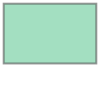

In [92]:
ROI = m.draw_features
if not ROI:
    print("Please, select an area of interest on the map")
else:
    polygon_ROI = shape(ROI[0]['geometry'])
    print("This is the shape of the selected ROI: \n")
    display(polygon_ROI)

In [93]:
station = get_station_location()
intersection = polygon_ROI.intersection(station.geometry)
new=station.copy()
c=0
for i in intersection:
    if i.is_empty:
        new=new.drop(c)
    c+=1
print(len(new.id_stazione),"stations out of",c,"are inside the selected area\n")
lista = new.id_stazione.tolist() #Converto to a list the stations inside the area
list_sensors_inside_area=list_sensors_and_pollutants(lista) #seach for all sensors inside the area
df = pd.DataFrame(list_sensors_inside_area) #created a df with all the sensors inside the area

18 stations out of 175 are inside the selected area



In [94]:
if df is None:
    print("The selected area does not contain any sensors, please try with another area")
else:
    m = folium.Map(location=[45.64, 9.60], zoom_start=8, tiles="OpenStreetMap")
    fg_active = folium.FeatureGroup(name="Active station", show=True).add_to(m)
    fg_inactive = folium.FeatureGroup(name="Inactive station", show=True).add_to(m)
    # iterate through the GeoDataFrame and add a marker for each station by extracting its coordinates and the popup content
    for index, row in new.iterrows():
        filtro = df[df['id_stazione'] == row['id_stazione'] ]
        filtro = filtro.drop('id_stazione', axis=1)
        html = (f"<b>Dati rilevati nella stazione {row['id_stazione']} - {row['nome_stazione']}</b><br><br>"
        + filtro.to_html(
        classes="table table-striped table-hover table-condensed table-responsive",
        index=False))
        popup = folium.Popup(html)

        if filtro["data_stop"].isna().any():
            folium.Marker(
                location=[row['geometry'].y,row['geometry'].x], 
                popup=popup,
                icon=folium.map.Icon(color='red')
            ).add_to(fg_active)
        else:
            folium.Marker(
                location=[row['geometry'].y,row['geometry'].x], 
                popup=popup,
                icon=folium.map.Icon(color='gray')
            ).add_to(fg_inactive)
        
    #Add province layer
    geojson = mapping(polygon_ROI) 
    folium.GeoJson(geojson, name="Selected area" ).add_to(m)
    lombardia = prov.dissolve()  
    geojson2 = mapping(lombardia)
    folium.GeoJson(geojson2, name="Lombardia").add_to(m)
    folium.LayerControl().add_to(m)
    display(m)